### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import math
import random
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import os
os.chdir('C:/Users/jackj/OneDrive/Documents/MSc/ML2/Coursework 2 - Classification')

### Setup Dataframe & Short EDA

In [2]:
columns = [
    'pelvic_inc',
    'pelvic_tilt',
    'lumbar_angle',
    'sacral_slope',
    'pelvic_radius',
    'spond_tilt',
    'normality'
]
df = pd.read_csv('vertebral_column_data.txt', delim_whitespace=True, header=None, names=columns)

pd.get_dummies(df, 'normality')
df = pd.get_dummies(df, 'normality')
del df['normality_NO']
df.rename(columns={'normality_AB':'abnormal'}, inplace=True)

In [3]:
df.head(5)

,pelvic_inc,pelvic_tilt,lumbar_angle,sacral_slope,pelvic_radius,spond_tilt,abnormal
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


In [4]:
df.shape

(310, 7)

In [5]:
print("Abnormal cases: "+str(len(df[df['abnormal']==1])))
print("Normal cases: "+str(len(df[df['abnormal']==0])))

Abnormal cases: 210
Normal cases: 100


### Using Dimensionality Reduction on the Data & Building Supervised Classifiers 

In [6]:
def standardize_data(df):
    df_x = df.iloc[:,:-1]
    df_std = pd.DataFrame(StandardScaler().fit_transform(df_x))
    return df_std

# Create dimensionality reduction functions
def fit_umap(data):
    model = umap.UMAP()
    reduced_data = model.fit_transform(data)
    return reduced_data

def fit_pca(data):
    model = PCA(n_components=2)
    reduced_data = model.fit_transform(data)
    return reduced_data

def fit_tsne(data):
    model = TSNE(n_components=2)
    reduced_data = model.fit_transform(data)
    return reduced_data

def balance_data(reduced_data, normality):
    to_remove = random.sample(range(normality.count(1)), normality.count(1)-normality.count(0))
    for index in sorted(to_remove, reverse=True):
        reduced_data = np.delete(reduced_data, index, axis=0)
        normality = normality[:index] + normality[index+1 :]
    return reduced_data, normality
    
def split_comps(reduced_data):
    comp1 = reduced_data[:,0]
    comp2 = reduced_data[:,1]
    return comp1, comp2

def kde_plot_classified(normality, comp1, comp2):
    color = ['red' if i == 1 else 'blue' for i in normality]
    # Make a plot as part of EDA
    plt.figure(figsize=(6,6))
    plt.scatter(comp1, comp2, c=color, marker='o', s=25, edgecolor='black')
    no_abnrm = normality.count(1)
    no_nrm = normality.count(0)
    sns.kdeplot(comp1[:no_abnrm], comp2[:no_abnrm], cmap="Reds")
    sns.kdeplot(comp1[:no_nrm], comp2[:no_nrm], cmap="Blues")
    plt.xlabel('Component 1', fontweight='bold')
    plt.ylabel('Component 2', fontweight='bold')
    plt.title('KDE Plot of Components', fontweight='bold')
    plt.show()
    
def dimensionality_reduction(reduced_data, normality):  
    balanced_reduced_data, balanced_normality = balance_data(reduced_data, normality)
    comp1, comp2 = split_comps(balanced_reduced_data)
    kde_plot_classified(balanced_normality, comp1, comp2)
    
    return balanced_reduced_data, balanced_normality, comp1, comp2

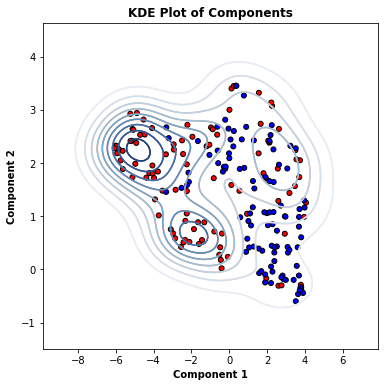

In [7]:
# Plot initial dimensionality reduction (UMAP)
normality = list(df['abnormal'])
df_std = standardize_data(df)
reduced_data = fit_umap(df_std)

reduced_data, normality, comp1, comp2 = dimensionality_reduction(reduced_data, normality)

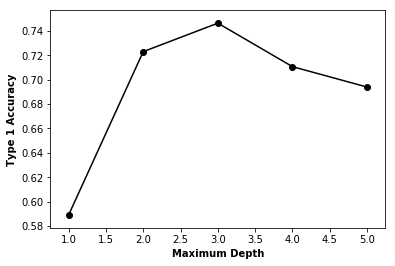

In [23]:
# Optimize the maximum depth of the Decision Tree classifier
def parameter_optimisation(components, normality):
    all_scores = []
    for k in range(1,10):
        balanced_reduced_data, balanced_normality = balance_data(components, normality)
        average_scores = []
        for i in range(1,6):
            cv_scores = []
            for j in range(50):
                X_train, X_test, y_train, y_test = train_test_split(balanced_reduced_data, balanced_normality, test_size=0.25,
                                                                        random_state = random.randint(1,200))
                model = DecisionTreeClassifier(max_depth=i)
                model.fit(X_train, y_train)
                y_test_predict = model.predict(X_test)
                conf_mat = confusion_matrix(y_test, y_test_predict)
                type1 = conf_mat[1][1]/sum(conf_mat[1])
                cv_scores.append(type1)
            average_scores.append(np.mean(cv_scores))
        all_scores.append(average_scores)

    all_score_average = np.mean(all_scores, axis=0)      
    plt.plot(range(1,6), all_score_average, color = 'black')
    plt.scatter(range(1,6), all_score_average, facecolor = 'black')
    plt.xlabel('Maximum Depth', fontweight='bold')
    plt.ylabel('Type 1 Accuracy', fontweight='bold')
    
parameter_optimisation(components, normality)

In [8]:
# Build Supervised Classifiers & Model Performance Metrics + Vis.
def gaussianNB_classify(reduced_data, normality):
    model = GaussianNB()
    model.fit(reduced_data, normality)
    return model

def knn_classify(reduced_data, normality):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(reduced_data, normality)
    return model

def svc_classify(reduced_data, normality):
    model = svm.SVC(kernel='linear', C=0.025)
    model.fit(reduced_data, normality)
    return model

def decisionTree_classify(reduced_data, normality):
    model = DecisionTreeClassifier(max_depth=2)
    model.fit(reduced_data, normality)
    return model
                             

# Need to create 3 more classification algos and repeat the test

def model_accuracy(model, reduced_data, normality):
    predict = model.predict(reduced_data)
    accuracy = metrics.accuracy_score(normality, predict)
    print("Model accuracy is: "+str(round(accuracy*100,1))+"%")
    return accuracy

def set_meshgrid(comp1, comp2):
    comp1_min = math.floor(min(comp1))*0.95
    comp1_max = math.ceil(max(comp1))*1.05
    comp2_min = math.floor(min(comp2))*0.95
    comp2_max = math.ceil(max(comp2))*1.05
    h = 0.1
    xg, yg = np.meshgrid(np.arange(comp1_min, comp1_max, h),np.arange(comp2_min, comp2_max, h))
    
    return xg, yg, comp1_min, comp1_max, comp2_min, comp2_max

def draw_classifier(model, normality, xg, yg, comp1_min, comp1_max, comp2_min, comp2_max):
    color = ['red' if i == 1 else 'blue' for i in normality]
    predict_all = model.predict(np.c_[xg.ravel(), yg.ravel()])
    predict_all = predict_all.reshape(xg.shape)
    plt.figure(figsize=(6,6))
    plt.xlim((comp1_min,comp1_max))
    plt.ylim((comp2_min,comp2_max))
    plt.scatter(comp1, comp2, c=color, marker='o', s=25, edgecolor='black')
    plt.contourf(xg, yg, predict_all, cmap=plt.cm.RdBu_r, alpha=.5)
    plt.title('2 Dimensional Classifier', fontweight='bold')
    plt.xlabel('Component 1', fontweight='bold')
    plt.ylabel('Component 2', fontweight='bold')
    plt.show()
    
def draw_confusion(model, reduced_data, normality):
    predict = model.predict(reduced_data)
    conf_mat = confusion_matrix(normality, predict)
    ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', annot_kws={"size":13})
    ax.xaxis.set_ticklabels(['Predicted Normal', 'Predicted Abnormal'], ha='center', fontweight='bold')
    ax.yaxis.set_ticklabels(['Actual Normal', 'Actual Abnormal'], va='center', fontweight='bold')
    plt.show(ax)
    return conf_mat

def score_confusion(conf_mat):
    type1 = conf_mat[1][1]/sum(conf_mat[1])
    type2 = conf_mat[0][0]/sum(conf_mat[0])
    print("Abnormal cases correctly classified: "+str(round(type1*100,1))+"%")
    print("Normal cases correctly classified: "+str(round(type2*100,1))+"%")
    
def model_scoring(model, reduced_data, normality, comp1, comp2):
    accuracy = model_accuracy(model, reduced_data, normality)
    xg, yg, comp1_min, comp1_max, comp2_min, comp2_max = set_meshgrid(comp1, comp2)
    draw_classifier(model, normality, xg, yg, comp1_min, comp1_max, comp2_min, comp2_max)
    conf_mat = draw_confusion(model, reduced_data, normality)
    score_confusion(conf_mat)


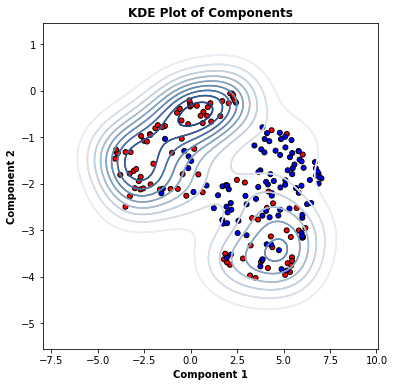

Model accuracy is: 85.5%


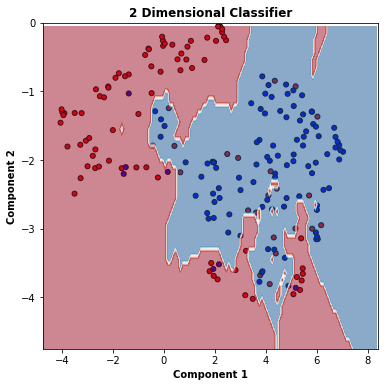

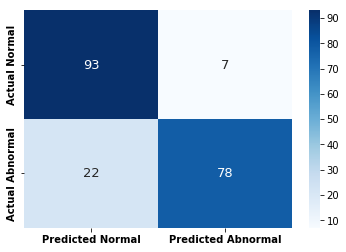

Abnormal cases correctly classified: 78.0%
Normal cases correctly classified: 93.0%


In [9]:
# Run all three reduction techniques through KNN classifier and score
normality = list(df['abnormal'])
df_std = standardize_data(df)

reduced_data_umap = fit_umap(df_std)
reduced_data_pca = fit_pca(df_std)
reduced_data_tsne = fit_tsne(df_std)

reduction_techniques = [reduced_data_umap, reduced_data_pca, reduced_data_tsne]

for components in reduction_techniques:
    balanced_reduced_data, balanced_normality, comp1, comp2 = dimensionality_reduction(components, normality)
    model = knn_classify(balanced_reduced_data, balanced_normality)
    model_scoring(model, balanced_reduced_data, balanced_normality, comp1, comp2)


[Text(0, 0.5, 'Naive Bayes'),
 Text(0, 1.5, 'kNN'),
 Text(0, 2.5, 'SVC'),
 Text(0, 3.5, 'Decision Tree')]

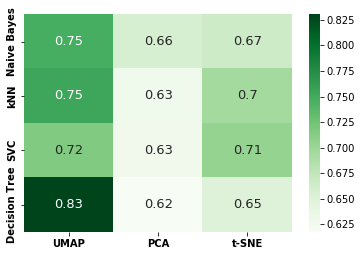

In [22]:
# Crossvalidate the performance of all combinations of DR + Classification#
# Visualize the results as heatmap of model performance
def cv_all_methods(df_std):
    normality = list(df['abnormal'])
    df_std = standardize_data(df)

    reduced_data_umap = fit_umap(df_std)
    reduced_data_pca = fit_pca(df_std)
    reduced_data_tsne = fit_tsne(df_std)

    reduction_techniques = [reduced_data_umap, reduced_data_pca, reduced_data_tsne]
    models = [gaussianNB_classify, knn_classify, svc_classify, decisionTree_classify]

    all_errors = []
    for model in models:
        model_errors = []
        for components in reduction_techniques:
            type1_errors = []
            i = 0 
            while i < 500:
                balanced_reduced_data, balanced_normality = balance_data(components, normality)
                X_train, X_test, y_train, y_test = train_test_split(balanced_reduced_data, balanced_normality, test_size=0.25,
                                                                    random_state = random.randint(1,200))
                fitted_model = model(X_train, y_train)
                y_test_predict = fitted_model.predict(X_test)
                conf_mat = confusion_matrix(y_test, y_test_predict)
                type1 = conf_mat[1][1]/sum(conf_mat[1])
                type1_errors.append(type1)
                i += 1
            model_errors.append(np.mean(type1_errors))
        all_errors.append(model_errors)
    return all_errors, reduction_techniques, models

all_errors, reduction_techniques, models = cv_all_methods(df_std)

ax = sns.heatmap(all_errors, cmap='Greens', annot=True, annot_kws={"size":13})
ax.xaxis.set_ticklabels(['UMAP', 'PCA', 't-SNE'], ha='center', fontweight='bold')
ax.yaxis.set_ticklabels(['Naive Bayes', 'kNN', 'SVC', 'Decision Tree'], va='center', fontweight='bold')

### Unsupervised

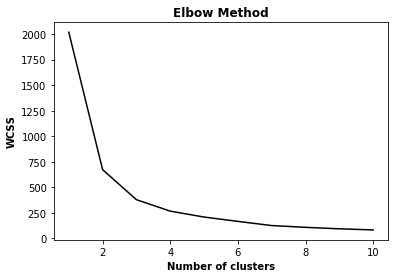

In [21]:
# Elbow method to score K Means (unsupervised)
scores = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(balanced_reduced_data)
    scores.append(kmeans.inertia_)
plt.plot(range(1, 11), scores, c='black')
plt.title('Elbow Method', fontweight='bold')
plt.xlabel('Number of clusters', fontweight='bold')
plt.ylabel('WCSS', fontweight='bold')
plt.show()

In [17]:
# Ugly function to include the centroid of each classification technique 
def find_centroid_coords(comp1, comp2):
    group1X = []
    group1Y = []
    group2X = []
    group2Y = []
    group3X = []
    group3Y = []

    for i in range(len(comp1)):
        if predict[i] == 0:
            group1X.append(comp1[i])
            group1Y.append(comp2[i])
        if predict[i] == 1:
            group2X.append(comp1[i])
            group2Y.append(comp2[i])
        if predict[i] == 2:
            group3X.append(comp1[i])
            group3Y.append(comp2[i])

    group1_center_X = np.mean(group1X)
    group1_center_Y = np.mean(group1Y)
    group2_center_X = np.mean(group2X)
    group2_center_Y = np.mean(group2Y)
    group3_center_X = np.mean(group3X)
    group3_center_Y = np.mean(group3Y)
    
    return group1_center_X, group1_center_Y, group2_center_X, group2_center_Y, group3_center_X, group3_center_Y

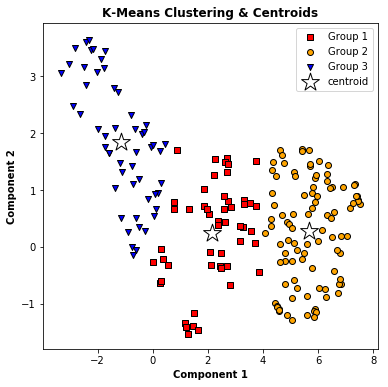

In [18]:
# K Means with explainable vis.
comp1, comp2 = split_comps(balanced_reduced_data)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(balanced_reduced_data)
predict = kmeans.predict(balanced_reduced_data)


marker_mapping = {0 : 's', 1: 'o', 2: 'v'}
color_mapping = {0: 'Red', 1: 'Orange', 2: 'Blue'}
label_mapping = {0: 'Group 1', 1: 'Group 2', 2: 'Group 3'}

ax = plt.figure(figsize=(6,6))
labelled = []
for i in range(len(comp1)):
    if label_mapping[predict[i]] not in labelled:
        if label_mapping[predict[i]] == 'Group 3' and 'Group 2' not in labelled:
            label = None
            pass
        else:
            label = label_mapping[predict[i]]
            labelled.append(label)
    else:
        label = None
        pass 
    plt.scatter(comp1[i], comp2[i], c=color_mapping[predict[i]], marker=marker_mapping[predict[i]],
                label = label, edgecolor='black')

    
group1_center_X, group1_center_Y, group2_center_X, group2_center_Y, group3_center_X, group3_center_Y = find_centroid_coords(comp1, comp2)
plt.scatter(group1_center_X,group1_center_Y, c='White', marker='*', edgecolor='black', s=350, label='centroid')
plt.scatter(group2_center_X,group2_center_Y, c='White', marker='*', edgecolor='black', s=350)
plt.scatter(group3_center_X,group3_center_Y, c='White', marker='*', edgecolor='black', s=350)

plt.title('K-Means Clustering & Centroids', fontweight='bold')
plt.xlabel('Component 1', fontweight='bold')
plt.ylabel('Component 2', fontweight='bold')

plt.legend(scatterpoints=1)

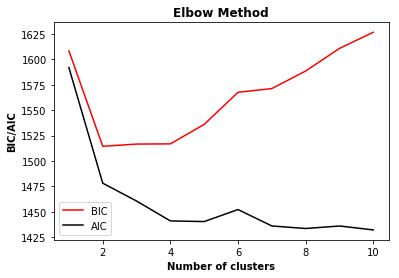

In [19]:
# Using BIC/AIC for Gaussian Mixture model
bic_scores = []
aic_scores = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i)
    model = gmm.fit(balanced_reduced_data)
    bic_scores.append(model.bic(balanced_reduced_data))
    aic_scores.append(model.aic(balanced_reduced_data))
plt.plot(range(1, 11), bic_scores, label='BIC', c='Red')
plt.plot(range(1,11), aic_scores, label='AIC', c='Black')
plt.title('Elbow Method', fontweight='bold')
plt.xlabel('Number of clusters', fontweight='bold')
plt.ylabel('BIC/AIC', fontweight='bold')
plt.legend(scatterpoints=1)
plt.show()

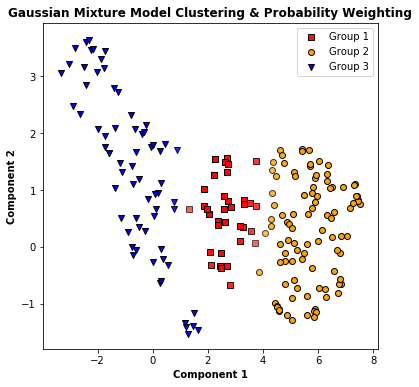

In [20]:
# Again, classify with explainable vis.
comp1, comp2 = split_comps(balanced_reduced_data)
gmm = GaussianMixture(n_components=3)
model = gmm.fit(balanced_reduced_data)
predict = model.predict(balanced_reduced_data)
probability = model.predict_proba(balanced_reduced_data)

marker_mapping = {0 : 's', 2: 'o', 1: 'v'}
color_mapping = {0: 'Red', 2: 'Orange', 1: 'Blue'}
label_mapping = {0: 'Group 1', 2: 'Group 2', 1: 'Group 3'}

ax = plt.figure(figsize=(6,6))
labelled = []
for i in range(len(comp1)):
    if label_mapping[predict[i]] not in labelled:
        if label_mapping[predict[i]] == 'Group 3' and 'Group 2' not in labelled:
            label = None
            pass
        else:
            label = label_mapping[predict[i]]
            labelled.append(label)
    else:
        label = None
        pass 
    confidence = probability[i][predict[i]]
    plt.scatter(comp1[i], comp2[i], c=color_mapping[predict[i]], marker=marker_mapping[predict[i]],
                label = label, edgecolor='black', alpha=confidence)

plt.title('Gaussian Mixture Model Clustering & Probability Weighting', fontweight='bold')
plt.xlabel('Component 1', fontweight='bold')
plt.ylabel('Component 2', fontweight='bold')

plt.legend(scatterpoints=1)
